<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/00_create_vegetation_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Vegetation Mask Creation from Multispectral Imagery

A geospatial image processing workflow that creates vegetation masks from 
multispectral raster data using NDVI (Normalized Difference Vegetation Index) 
classification and morphological filtering.

Overview:
    This pipeline processes true color orthophoto (DOP) imagery with near-infrared
    bands to identify and extract vegetation areas in Berlin. The workflow calculates
    NDVI values, classifies vegetation density, applies smoothing filters, and
    converts the result to vector geometries with spatial buffers.

Main Sections:
    
    1. Setup & Configuration
       - Mount Google Drive and install dependencies
       - Configure file paths for input DOP imagery and output directory
       - Set up area of interest (AOI) parameters
    
    2. Data Exploration & Metadata
       - Read multispectral raster metadata (CRS, bounds, bands)
       - Extract NIR (Band 1) and Red (Band 2) spectral data
       - Compute per-band statistics and percentiles
    
    3. NDVI Calculation
       - Compute Normalized Difference Vegetation Index: (NIR - Red) / (NIR + Red)
       - Analyze NDVI distribution with statistics and histogram
       - Visualize NDVI values as raster imagery
    
    4. NDVI Classification
       - Classify pixels into vegetation density classes:
         * Water: NDVI < 0
         * Bare soil: 0 ≤ NDVI < 0.2
         * Sparse vegetation: 0.2 ≤ NDVI < 0.6
         * Dense vegetation: NDVI ≥ 0.6
       - Export classified raster with categorical colormap
       - Visualize classification results
    
    5. Binary Vegetation Mask Creation
       - Convert NDVI to binary mask using threshold (NDVI > 0.16)
       - Separate vegetation from non-vegetation pixels
       - Export unsmoothed binary mask to GeoTIFF
    
    6. Morphological Filtering & Smoothing
       - Apply median filter (5×5 kernel) to reduce noise
       - Re-threshold filtered result to binary
       - Smooth jagged vegetation boundaries
    
    7. Vector Conversion & Buffering
       - Convert raster mask to vector polygons (GeoDataFrame)
       - Apply 1-meter spatial buffer around vegetation patches
       - Simplify geometry with 1-meter tolerance
       - Dissolve overlapping geometries into single features
       - Export final vector mask as GeoPackage (GPKG)

Key Data:
    - Input: True Color Orthophoto (DOP) with NIR bands (4 bands total)
    - Processing: NDVI calculation, threshold-based classification, morphological ops
    - Output:
        * NDVI raster (float32)
        * Classified NDVI raster (categorical)
        * Binary vegetation mask (uint8) - unsmoothed
        * Binary vegetation mask (uint8) - smoothed
        * Vector vegetation mask with buffers (GPKG)

CRS:
    - EPSG:25833 (UTM Zone 33N) - Standard for Berlin/Germany region
    - CRS automatically detected from input raster

Input Format:
    - GeoTIFF raster with 4 bands (NIR, Red, Green, Blue)
    - Band 1: Near-infrared (NIR)
    - Band 2: Red
    - Bands 3-4: Green and Blue (metadata)

Output Locations:
    - {aoi_code}/vegetation_mask/ndvi.tif - Raw NDVI values
    - {aoi_code}/vegetation_mask/ndvi_classified.tif - Classified NDVI (4 classes)
    - {aoi_code}/vegetation_mask/veg_mask_unsmoothed.tif - Binary mask (no filtering)
    - {aoi_code}/vegetation_mask/veg_mask_smoothed.tif - Binary mask (median filtered)
    - {aoi_code}/vegetation_mask/veg_mask_buffered.gpkg - Vector polygons with buffers

Parameters:
    - NDVI vegetation threshold: 0.16
    - Median filter kernel size: 5×5 pixels
    - Vector buffer distance: 1 meter
    - Geometry simplification tolerance: 1 meter
"""

# --- Setup ---

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio numpy

In [19]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import os

# --- Configuration ---

In [ ]:
# Define AOI code
# aoi_code = '386_5818' # training data
aoi_code = '384_5816' # test data

base_drive = '/content/drive/My Drive/masterthesis/data'
raw_data_path = f'{base_drive}/raw/DOP/2020/truedop20cir_{aoi_code}_2_be_2020.tif'
veg_mask_path = f'{base_drive}/{aoi_code}/vegetation_mask'

# Create vegetation_mask directory if it doesn't exist
os.makedirs(veg_mask_path, exist_ok=True)

# Define output paths
INFILE = raw_data_path
OUT_MASK_unsmoothed = f'{veg_mask_path}/veg_mask_unsmoothed.tif'
OUT_MASK_smoothed = f'{veg_mask_path}/veg_mask_smoothed.tif'
OUT_CLASSIFIED = f'{veg_mask_path}/ndvi_classified.tif'
OUT_NDVI = f'{veg_mask_path}/ndvi.tif'
OUTPUT_VECTOR = f'{veg_mask_path}/veg_mask_buffered.gpkg'

In [ ]:
with rasterio.open(INFILE) as src:
    # Basic metadata
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Width × Height:", src.width, "×", src.height)
    print("Band count:", src.count)
    print("Indexes:", src.indexes)
    print("Dtypes:", src.dtypes)
    print("Descriptions:", src.descriptions)
    print("Tags:", src.tags())
    crs = src.crs
    transform = src.transform

    # Per-band tags & statistics
    for i in src.indexes:
        print(f"\n--- Band {i} ---")
        print("  Tags:", src.tags(i))   # any per-band metadata
        band = src.read(i).astype('float32')
        print("  min / max:", float(band.min()), "/", float(band.max()))
        # optionally, more stats:
        pcts = np.percentile(band, [2, 25, 50, 75, 98])
        print("  2/25/50/75/98 pct:", np.round(pcts, 2))


CRS: EPSG:25833
Bounds: BoundingBox(left=384000.0, bottom=5816000.0, right=386000.0, top=5818000.0)
Width × Height: 10000 × 10000
Band count: 3
Indexes: (1, 2, 3)
Dtypes: ('uint8', 'uint8', 'uint8')
Descriptions: (None, None, None)
Tags: {'AREA_OR_POINT': 'Area'}

--- Band 1 ---
  Tags: {}
  min / max: 0.0 / 255.0
  2/25/50/75/98 pct: [ 46.  87. 131. 180. 220.]

--- Band 2 ---
  Tags: {}
  min / max: 0.0 / 255.0
  2/25/50/75/98 pct: [ 34.  57. 101. 153. 213.]

--- Band 3 ---
  Tags: {}
  min / max: 0.0 / 255.0
  2/25/50/75/98 pct: [ 33.  58. 102. 145. 211.]


In [26]:
NIR_BAND = 1  # Band 1 is NIR
RED_BAND = 2  # Band 2 is Red

with rasterio.open(INFILE) as src:
    nir = src.read(NIR_BAND).astype('float32')
    red = src.read(RED_BAND).astype('float32')
    profile = src.profile

In [ ]:
# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)

In [28]:
print("NDVI range:", ndvi.min(), "to", ndvi.max())
print("Mean NDVI:", ndvi.mean())
print("Percentiles:", np.percentile(ndvi, [1,5,25,50,75,95,99]))

NDVI range: -0.99999994 to 1.0
Mean NDVI: 0.11529955
Percentiles: [-0.17460318 -0.13677812 -0.06963788  0.03381642  0.31343284  0.5029586
  0.58771932]


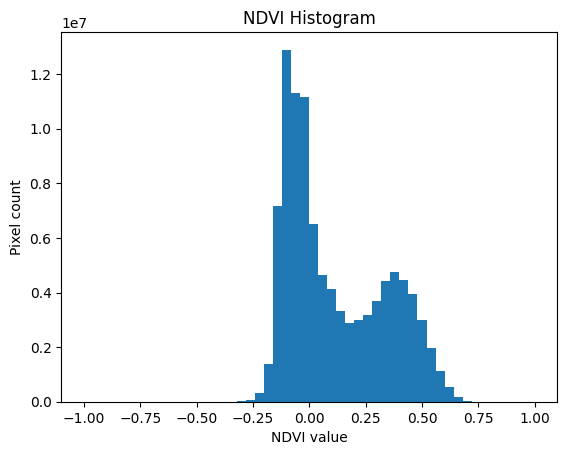

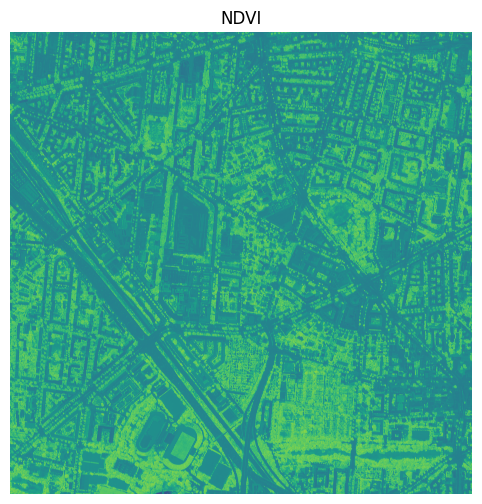

In [ ]:
# Plot NDVI as histogram
plt.figure()
plt.hist(ndvi.flatten(), bins=50)
plt.title('NDVI Histogram')
plt.xlabel('NDVI value')
plt.ylabel('Pixel count')
plt.show()

# Plot NDVI as raster
plt.figure(figsize=(8, 6))
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.title('NDVI')
plt.axis('off')
plt.show()

In [30]:
# WRITE ndvi
profile.update(
    dtype='float32',
    count=1,
    compress='lzw',
    nodata=np.nan
)

# Export the classified raster
with rasterio.open(OUT_NDVI, 'w', **profile) as dst:
    dst.write(ndvi, 1)

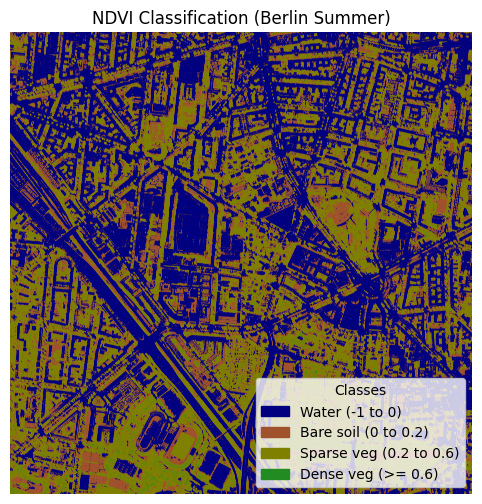

In [ ]:
# NDVI Classification Visualization
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define thresholds and labels
thresholds = {
    'Water (-1 to 0)':        (-1.0,  0.0),
    'Bare soil (0 to 0.2)':    (0.0,   0.2),
    'Sparse veg (0.2 to 0.6)': (0.2,   0.6),
    'Dense veg (>= 0.6)':      (0.6,   np.inf)
}
labels = list(thresholds.keys())

# Build the integer class map (same shape as ndvi)
class_map = np.full(ndvi.shape, -1, dtype=int)
for idx, label in enumerate(labels):
    low, high = thresholds[label]
    mask = (ndvi >= low) & (ndvi < high)
    class_map[mask] = idx

# Set up one color per class
cmap = ListedColormap([
    'navy',       # Water
    'sienna',     # Bare soil
    'olive',      # Sparse veg
    'forestgreen' # Dense veg
])

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(class_map, cmap=cmap, vmin=0, vmax=len(labels)-1)
ax.axis('off')
ax.set_title('NDVI Classification (Berlin Summer)')

# Add legend
patches = [mpatches.Patch(color=cmap(i), label=labels[i])
           for i in range(len(labels))]
ax.legend(handles=patches, loc='lower right', title='Classes', frameon=True)

plt.show()


In [ ]:
# Export the classified raster
with rasterio.open(OUT_CLASSIFIED, 'w', **profile) as dst:
    dst.write(class_map, 1)

print(f"Classified NDVI raster saved to: {OUT_CLASSIFIED}")

Classified NDVI raster saved to: /content/drive/My Drive/masterthesis/data/384_5816/vegetation_mask/ndvi_classified.tif


In [ ]:
# Create binary vegetation mask
veg_mask = (ndvi > 0.16).astype('uint8')

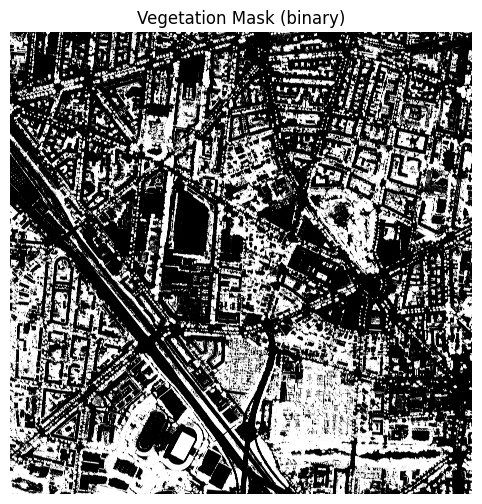

In [ ]:
# Plot binary vegetation mask
plt.figure(figsize=(8, 6))
plt.imshow(veg_mask, cmap='gray')
plt.title('Vegetation Mask (binary)')
plt.axis('off')
plt.show()

In [35]:
with rasterio.open(OUT_MASK_unsmoothed, 'w', **profile) as dst:
    dst.write(veg_mask, 1)

In [36]:
from scipy.ndimage import median_filter

# veg_mask is 0/1 uint8
# apply a 3×3 median → each pixel becomes the median of its 3×3 window
med = median_filter(veg_mask, size=5)

# threshold back to binary (if your code requires uint8)
veg_mask_smoothed = (med > 0).astype('uint8')

# Write the smoothed mask back to disk
with rasterio.open(OUT_MASK_smoothed, "w", **profile) as dst:
    dst.write(veg_mask_smoothed.astype(np.uint8), 1)

In [ ]:
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes

# Turn into a vector layer
results = (
    {'geometry': shape(geom), 'value': value}
    for geom, value in shapes(veg_mask_smoothed, mask=(veg_mask_smoothed == 1), transform=transform)
)

geoms = list(results)
gdf = gpd.GeoDataFrame.from_records(geoms)
gdf = gdf.set_geometry('geometry')
gdf.set_crs(crs, inplace=True)

,geometry,value
0,"POLYGON ((384982.2 5818000, 384982.2 5817999.8...",1.0
1,"POLYGON ((385254.6 5818000, 385254.6 5817999.8...",1.0
2,"POLYGON ((384045.8 5818000, 384045.8 5817999.6...",1.0
3,"POLYGON ((384382.6 5818000, 384382.6 5817999.8...",1.0
4,"POLYGON ((385156.2 5818000, 385156.2 5817999.8...",1.0
...,...,...
13729,"POLYGON ((385466.2 5816002, 385466.2 5816001.8...",1.0
13730,"POLYGON ((385553.6 5816000.4, 385553.6 5816000...",1.0
13731,"POLYGON ((385589.2 5816000.6, 385589.2 5816000...",1.0
13732,"POLYGON ((385596 5816001.2, 385596 5816000.6, ...",1.0


In [ ]:
# Apply 1 meter buffer
gdf['geometry'] = gdf['geometry'].buffer(1.0)

In [39]:
gdf['geometry'] = gdf['geometry'].simplify(tolerance=1.0, preserve_topology=True)

In [40]:
# (Optional) Drop the 'value' column
gdf = gdf.drop(columns=['value'])
gdf = gdf.dissolve()
gdf = gdf.reset_index(drop=True)
gdf.to_file(OUTPUT_VECTOR, driver='GPKG')